### Simple Example for Fitting a Generalized Linear Model (GLM) - Hidden Markov Model (HMM) 

This notebook is designed to help users get started using the glmhmm package to fit GLM-HMMs to their data. This notebook consists of two parts. In the first part, we use simulated data so that we can check that we are inferring the correct model parameters. It follows the same procedure as in the HMM fitting notebook, with the only changes being those necessary for fitting a GLM-HMM. 

In the second part, we apply the model to some real experimental data (as in [Bolkan, Stone et al 2021](https://www.biorxiv.org/content/10.1101/2021.07.23.453573v1)) and recreate some figures from that paper.

### Part 1: Simulated Data

#### 1. Import the required code packages and modules.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/Users/irisstone/Google Drive (istone@princeton.edu)/Princeton/Research/Striatum Towers Task/code/glmhmm")
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from glmhmm import glm_hmm
from glmhmm.utils import permute_states, find_best_fit
from glmhmm.visualize import plot_model_params

#### 2. Set the hyper-parameters of the GLM-HMM

In [2]:
N = 50000 # number of data/time points
K = 2 # number of latent states
C = 3 # number of observation classes
D = 4 # number of GLM inputs (regressors)

#### 3. Instantiate the model and generate true parameters

The parameters of a GLM-HMM include the transition probabilities $A$, the GLM weights $w$, and the initial state probabilities $\pi$. The distribution class of the observations can be either "Bernoulli", meaning the observations $y$ take on values of 0 or 1, or "multinomial", meaning the observations can take on integer values from 0 to $C$ (specified above), i.e. $y \in \{0,...,C\}$.

In [3]:
true_GLMHMM = glm_hmm.GLMHMM(N,D,C,K,observations="multinomial")
A_true,w_true,pi_true = true_GLMHMM.generate_params(weights=['uniform',-1,1,1])

#### 4. Given the true parameters, generate some data. 

The data include the observations $y$, the inputs $x$, and the latent states $z$ at each time point. 

In [4]:
true_y,true_z,true_x = true_GLMHMM.generate_data(A_true,w_true)

#### 5. Fit the model

The fitting code uses the expectation maximization (EM) algorithm to infer the model parameters. Because EM does not guarantee that it will find the best fit (global optimum) and inference is often dependent on the choice of parameter initialization, it is often best to fit the model multiple times using different initializations and then select the best one based on which fit obtained the highest log-likelihood. <b>Note:</b> For this example, we are not inferring the initial state probabilities, but instead assuming a uniform distribution over the initial states. See the deterministic annealing HMM notebook for an example where we also infer the initial state probabilities.

In [5]:
inits = 2 # set the number of initializations

# store values for each initialization
lls_all = np.zeros((inits,250))
A_all = np.zeros((inits,K,K))
w_all = np.zeros((inits,K,D,C))

# fit the model for each initialization
for i in range(inits):
    A_init,w_init,pi_init = true_GLMHMM.generate_params() # initialize the model parameters
    lls_all[i,:],A_all[i,:,:],w_all[i,:,:],pi0 = true_GLMHMM.fit(true_y,true_x,A_init,w_init) # fit the model
    print('initialization %s complete' %(i+1))

initialization 1 complete
initialization 2 complete


In [6]:
def plot_weights(w,ax,xlabels=None,color=None,style='-',label=''):
    
    import itertools
    
    if color is not None:
        colors = itertools.cycle(color)
        ax.plot(w.T,color=next(colors),linestyle=style,label=label)
    else:
        ax.plot(w.T,linestyle=style,label=label)
    ax.set_xlabel('input labels',fontsize=16)
    ax.set_ylabel('weight',fontsize=16)
    if xlabels:
        ax.set_xticks(np.arange(0,len(xlabels)))
        ax.set_xticklabels(xlabels)

Text(0.5, 1.0, 'obs class 2')

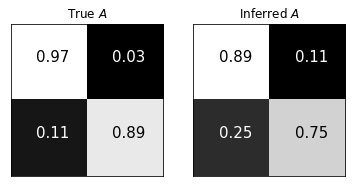

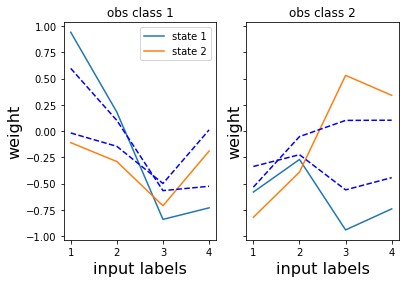

In [7]:
bestix = find_best_fit(lls_all) # find the initialization that led to the best fit

# for easy comparison permute the states in order from highest to lowest self-transition probability
A_permuted, order = permute_states(A_all[bestix])
A_true_permuted, order_true = permute_states(A_true)

# plot the true vs. inferred transition probabilities
fig, ax = plt.subplots(1,2,sharey=True)
    
plot_model_params(A_true_permuted,ax[0])
plot_model_params(A_permuted, ax[1])

ax[0].set_title('True $A$')
ax[1].set_title('Inferred $A$')

# permute the observation probability matrices according to the above order
w_permuted,_ = permute_states(w_all[bestix],method='order',param='weights',order=order)
w_true_permuted,_ = permute_states(w_true,method='order',param='weights',order=order_true)

# plot the true vs. inferred observation probabilities
fig, ax = plt.subplots(1,2,sharey=True)
#,[237,177,32],[233,0,111],[176,100,245]
    
colors = np.array([[39,110,167],[237,177,32]])/255
for c in range(0,C-1):
    plot_weights(w_true_permuted[:,:,c+1],ax[c],xlabels=['1','2','3','4','5'])
    plot_weights(w_permuted[:,:,c+1], ax[c],color=['b','o'],style='--')

ax[0].legend(['state 1','state 2'])
ax[0].set_title('obs class 1')
ax[1].set_title('obs class 2')


#### 7. Cross validation can further assess model performance.

We can also compare the true vs inferred log-likelihood to see how close we came to the global optimum in our fitting procedure. The best way to do this is to use cross validation, where we split the data into training and test sets and compare the log-likelihoods of the test data. To be rigorous, we should use <i>multi-fold</i> cross-validation, where we split the data into multiple (non-overlapping) train and test sets, fit the model to each of the train sets, evaluate the log-likelihood on each of the test sets, and then take the average. 

In [341]:
# split the data into five folds
folds = 5
train_size = int(N - N/folds)
test_size = int(N/folds)
y_train = np.zeros((folds,train_size))
y_test = np.zeros((folds,test_size))
x_train = np.zeros((folds,train_size,D))
x_test = np.zeros((folds,test_size,D))
kf = KFold(n_splits=folds)
kf.get_n_splits(true_y)
for i, (train_index, test_index) in enumerate(kf.split(true_y)):
    y_train[i,:], y_test[i,:] = true_y[train_index], true_y[test_index]
    x_train[i,:,:], x_test[i,:,:] = true_x[train_index], true_x[test_index]

In [342]:
inits = 2 # set the number of initializations
true_GLMHMM.n = train_size # reset the number of data points in accordance with the size of the training set
# store values for each initialization
lls_all = np.zeros((folds,inits,250)) # 250 is max default number of iterations
A_all = np.zeros((folds,inits,K,K))
w_all = np.zeros((folds,inits,K,D,C))

# fit the model for each training set and each initialization
for i in range(folds):
    for j in range(inits):
        A_init,w_init,pi_init = true_GLMHMM.generate_params() # initialize the model parameters
        lls_all[i,j,:],A_all[i,j,:,:],w_all[i,j,:,:],pi0 = true_GLMHMM.fit(y_train[i],x_train[i],A_init,w_init) # fit the model
        print('initialization %s complete' %(j+1))
    print('fold %s complete \n' %(i+1))

initialization 1 complete
initialization 2 complete
fold 1 complete 

initialization 1 complete
initialization 2 complete
fold 2 complete 

initialization 1 complete
initialization 2 complete
fold 3 complete 

initialization 1 complete
initialization 2 complete
fold 4 complete 

initialization 1 complete
initialization 2 complete
fold 5 complete 



In [343]:
true_GLMHMM.n = test_size # reset the number of data points in accordance with the size of the test set

# store values for each fold
true_ll = np.zeros(folds)
fit_ll = np.zeros(folds)
    
# evaluate log-likelihood on each test set
for i in range(5):
    
    # convert true weights into observation probabilities for each state
    phi_true = np.zeros((test_size,K,C))
    for k in range(K):
        phi_true[:,k,:] = true_GLMHMM.glm.compObs(x_test[i],w_true[k,:,:])
    
    bestix = find_best_fit(lls_all[i,:,:]) # find the initialization that led to the best fit
    # convert inferred weights into observation probabilities for each state
    phi = np.zeros((test_size,K,C))
    for k in range(K):
        phi[:,k,:] = true_GLMHMM.glm.compObs(x_test[i],w_all[i,bestix,k,:,:])
        
    # compute true and inferred log-likelihoods
    true_ll[i],_,_ = true_GLMHMM.forwardPass(y_test[i,:],A_true,phi_true,pi0=None)
    fit_ll[i],_,_ = true_GLMHMM.forwardPass(y_test[i,:],A_all[i,bestix],phi)

# compare loglikelihoods
print('True LL: %f' %(np.mean(true_ll)))
print('Inferred LL: %f' %(np.mean(fit_ll)))

True LL: -2866.226403
Inferred LL: -3714.126655


### Part 2: Real Data

The real data that we will use in this case comes from the experiments described in [Bolkan, Stone et al 2021](https://www.biorxiv.org/content/10.1101/2021.07.23.453573v1). This is behavioral data from mice performing a two alternative forced choice (2AFC) task in which the animals run down a virtual maze while multi-sensory "cues" appear to their left and right. The mice must "accumulate evidence" as these cues appear and ultimately make a decision to turn left or right based on which side of the maze had more cues.

The dataset in the paper includes three cohorts of mice: a group that was inhibited in the direct pathway of the striatum, a group that was inhibited in the indirect pathway, and a control (no opsin) group. Below we will fit a GLM-HMM to the "indirect pathway group", but this repository includes data for the other cohorts as well, should you want to take a look.

#### 1. Load the data

In [25]:
x = np.load('../data/indirect_x.npy') # z-scored design matrix
y = np.load('../data/indirect_y.npy') # vector of right and left choices for each trial

#### 2. Set the hyper-parameters of the GLM-HMM.

In [20]:
N = x.shape[0] # number of data/time points
K = 3 # number of latent states
C = 2 # number of observation classes
D = x.shape[1] # number of GLM inputs (regressors)

#### 3. Instantiate the model.

In [22]:
real_GLMHMM = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli")

#### 3. Fit the model.

In [23]:
inits = 2 # set the number of initializations

# store values for each initialization
lls_all = np.zeros((inits,250))
A_all = np.zeros((inits,K,K))
w_all = np.zeros((inits,K,D,C))

# fit the model for each initialization
for i in range(inits):
    A_init,w_init,pi_init = real_GLMHMM.generate_params() # initialize the model parameters
    lls_all[i,:],A_all[i,:,:],w_all[i,:,:],pi0 = real_GLMHMM.fit(y,x,A_init,w_init) # fit the model
    print('initialization %s complete' %(i+1))

initialization 1 complete
initialization 2 complete


#### 4. Check to see that multiple fits achieve the same log-likelihood.

Since we're now fitting real data, we can't simply compare our inferred parameters to the true ones to make sure we're recovering the right values. But we can get a reasonable assessment of whether or not we're finding the global optimum of the log-likelihood by comparing the log-likelihoods for each fit. If multiple of the log-likelihoods for the best fits converge to the same (or very similar) values, this is a good indication that we've found the global optimum.

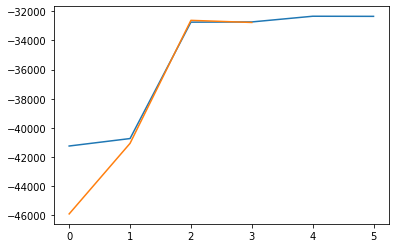

In [27]:
plt.plot(lls_all.T)

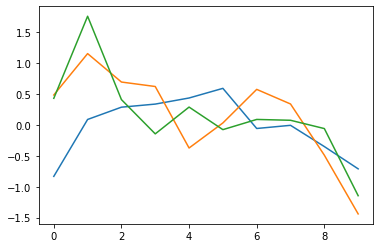

In [34]:
plt.plot(w_all[0,:,:,1].T)

#### 5. We can also check that the weights for the best fits are the same, within some tolerance.

#### 6. Now let's recreate some of the plots from the paper, [Bolkan, Stone et al 2021](https://www.biorxiv.org/content/10.1101/2021.07.23.453573v1). 